# Brain Encoding

As discusses earlier, Brain Encoding is the process of learning the mapping e from the stimuli S to the neural activation F.

We shall now try to implement a Ridge Regression-based Brain Encoding model using movie-10 dataset. 

## Importing  basic libraries

In [1]:
import json
import os
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
import pandas as pd
from ridge import bootstrap_ridge
from evalute import *
import scipy.stats as stats
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from Feature_extraction import *

import warnings
warnings.filterwarnings("ignore")

We will be using the "figures" movie data from the movie-10 dataset. This figures dataset includes about 120 minutes of functional data for all 6 participants. This movie was presented twice, but we'll go with first run of the movie. We will be working with one subject for the time being.

## Loading Fmri Data

The movie was divided into 12 smaller clips and and they were presented in different sessions. The Fmri was recorded after every 1.49 seconds (tr_time) while subjects viewed the video.

We take 2 sessions data in the train set and 1 session data in the test set

In [2]:
ses2clip_train = {'007': ['01','02','03'],
            '008': ['05','06','07','08','09']
           }

ses2clip_test = {'009': ['04','10','11','12']}

fmri_original_train = []
fmri_original_test = []

In [3]:
for ses in list(ses2clip_train.keys()):
    for clip in ses2clip_train[ses]:
        fmri_filepath = '../../../Desktop/movie10.fmriprep/sub-01/ses-'+ses+'/func/sub-01_ses-'+ses+'_task-figures'+clip+'_run-1_space-fsLR_den-91k_bold.dtseries.nii'
        img = nib.load(fmri_filepath)
        fmri_original_train.append(img.get_data())
        
for ses in list(ses2clip_test.keys()):
    for clip in ses2clip_test[ses]:
        fmri_filepath = '../../../Desktop/movie10.fmriprep/sub-01/ses-'+ses+'/func/sub-01_ses-'+ses+'_task-figures'+clip+'_run-1_space-fsLR_den-91k_bold.dtseries.nii'
        img = nib.load(fmri_filepath)
        fmri_original_test.append(img.get_data())
        

## Loading Stimuli and extracting Features

We will be extracting Visual and Audio features from the the stimuli i.e video clips. 
Each of the 12 clips were broken down into 1.49 second smaller clips and for each of them, we extract visual and ausio features. We can use librosa library to extract MFCC features for the audio.

In [4]:
video_feats_train = []
audio_feats_train = []

video_feats_test = []
audio_feats_test = []

## Extracting audio and video features from stimuli

# for ses in list(ses2clip_train.keys()):
#     for clip in ses2clip_train[ses]:
#         clip_filepath = '../../../Desktop/movie10.stimuli/figures/figures'+clip+'.mkv'
#         tr_time = json.load(open('../../../Desktop/movie10.fmriprep/sourcedata/movie10/task-figures'+clip+'_bold.json'))['RepetitionTime']
#         clip_video_feats, clip_audio_feats = extract_stimuli_features(clip_filepath,tr_time)
        
#         video_feats_train.append(clip_video_feats)
#         audio_feats_train.append(clip_audio_feats)
        
# for ses in list(ses2clip_test.keys()):
#     for clip in ses2clip_test[ses]:
#         clip_filepath = '../../../Desktop/movie10.stimuli/figures/figures'+clip+'.mkv'
#         tr_time = json.load(open('../../../Desktop/movie10.fmriprep/sourcedata/movie10/task-figures'+clip+'_bold.json'))['RepetitionTime']
#         clip_video_feats, clip_audio_feats = extract_stimuli_features(clip_filepath,tr_time)
        
#         video_feats_test.append(clip_video_feats)
#         audio_feats_test.append(clip_audio_feats)



## Loading pre-extracted features
for ses in list(ses2clip_train.keys()):
    for clip in ses2clip_train[ses]:
        video_feats_filepath = '../data/figures'+clip+'_video.npy'
        audio_feats_filepath = '../data/figures'+clip+'_audio.npy'
                
        video_feats_train.append(np.load(video_feats_filepath))
        audio_feats_train.append(np.load(audio_feats_filepath))
        
for ses in list(ses2clip_test.keys()):
    for clip in ses2clip_test[ses]:
        video_feats_filepath = '../data/figures'+clip+'_video.npy'
        audio_feats_filepath = '../data/figures'+clip+'_audio.npy'
                
        video_feats_test.append(np.load(video_feats_filepath))
        audio_feats_test.append(np.load(audio_feats_filepath))

## Creating Input and Target Matrices

There is generally a delay in neural activity peaking and the stimuli onset. Thus to account for this delay, we train our model to predict $y_{i}$ (Fmri) using concat($x_{i-6},x_{i-5},x_{i-4},x_{i-3},x_{i-2},x_{i-1}$) (stimuli features) 

In [6]:
k = 6

final_fmri_train = []
final_audio_feats_train = []
final_video_feats_train = []
final_fmri_test = []
final_audio_feats_test = []
final_video_feats_test = []


for i in range(len(audio_feats_train)):
    for j in range(0,audio_feats[i]_train.shape[0]-k+1):
        final_audio_feats_train.append(np.concatenate(audio_feats_train[i][j:j+k]))
        final_video_feats_train.append(np.concatenate(video_feats_train[i][j:j+k]))
        final_fmri_train.append(fmri_original_train[i][j+k])
    
for i in range(len(audio_feats_test)):
    for j in range(0,audio_feats[i]_test.shape[0]-k+1):
        final_audio_feats_test.append(np.concatenate(audio_feats_test[i][j:j+k]))
        final_video_feats_test.append(np.concatenate(video_feats_test[i][j:j+k]))
        final_fmri_test.append(fmri_original_test[i][j+k])
        
    
final_fmri_train = stats.zscore(np.array(final_fmri_train))
final_audio_feats_train = stats.zscore(np.array(final_audio_feats_train))
final_video_feats_train = stats.zscore(np.array(final_video_feats_train))
final_fmri_test = stats.zscore(np.array(final_fmri_test))
final_audio_feats_test = stats.zscore(np.array(final_audio_feats_test))
final_video_feats_test = stats.zscore(np.array(final_video_feats_test))

In [7]:
final_fmri_train = np.nan_to_num(final_fmri_train)
final_fmri_test = np.nan_to_num(final_fmri_test)

## Training the Model

### Ridge Regression

In [10]:
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

X_train = final_audio_feats_train
X_test = final_audio_feats_test

y_train = final_fmri_train
y_test = final_fmri_test


wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(X_train, y_train, X_test, y_test,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

In [12]:
y_pred = np.matmul(X_test,wt)

In [13]:
actual = y_test
predicted = y_pred

In [14]:
predicted = stats.zscore(predicted)
predicted = np.nan_to_num(predicted)

## Evaluation of Prediction

We evaluate our models using popular brain encoding evaluation metrics described in the following.Let $N$ be the number of samples. Let $\{Y_i\}_{i=1}^N$ and $\{\hat{Y}_i\}_{i=1}^N$ denote the actual and predicted voxel value vectors for the $i^{th}$ sample. Thus, $Y\in R^{N\times V}$ and $\hat{Y}\in R^{N\times V}$ where $V$ is the number of voxels in that region.

**2V2 Accuracy** is computed as 

$$\frac{1}{N_{C_2}}\sum_{i=1}^{N-1}\sum_{j=i+1}^N I[cosD(Y_i, \hat{Y}_i)+cosD(Y_j, \hat{Y}_j)<cosD(Y_i, \hat{Y}_j)+cosD(Y_j, \hat{Y}_i)]$$

where $cosD$ is the cosine distance function. $I[c]$ is an indicator function such that $I[c]=1$ if $c$ is true, else it is 0. The higher the 2V2 accuracy, the better.

**Pearson Correlation (PC)** is computed as 
$$\frac{1}{N}\sum_{i=1}^{n} corr[Y_i, \hat{Y}_i]$$

where corr is the correlation function.

In [15]:
acc = acc_2v2(actual, predicted)
p_corr = corr_pearson(actual, predicted)

In [16]:
print(acc,p_corr)

0.9265822784810127


## Analysing the Prediction

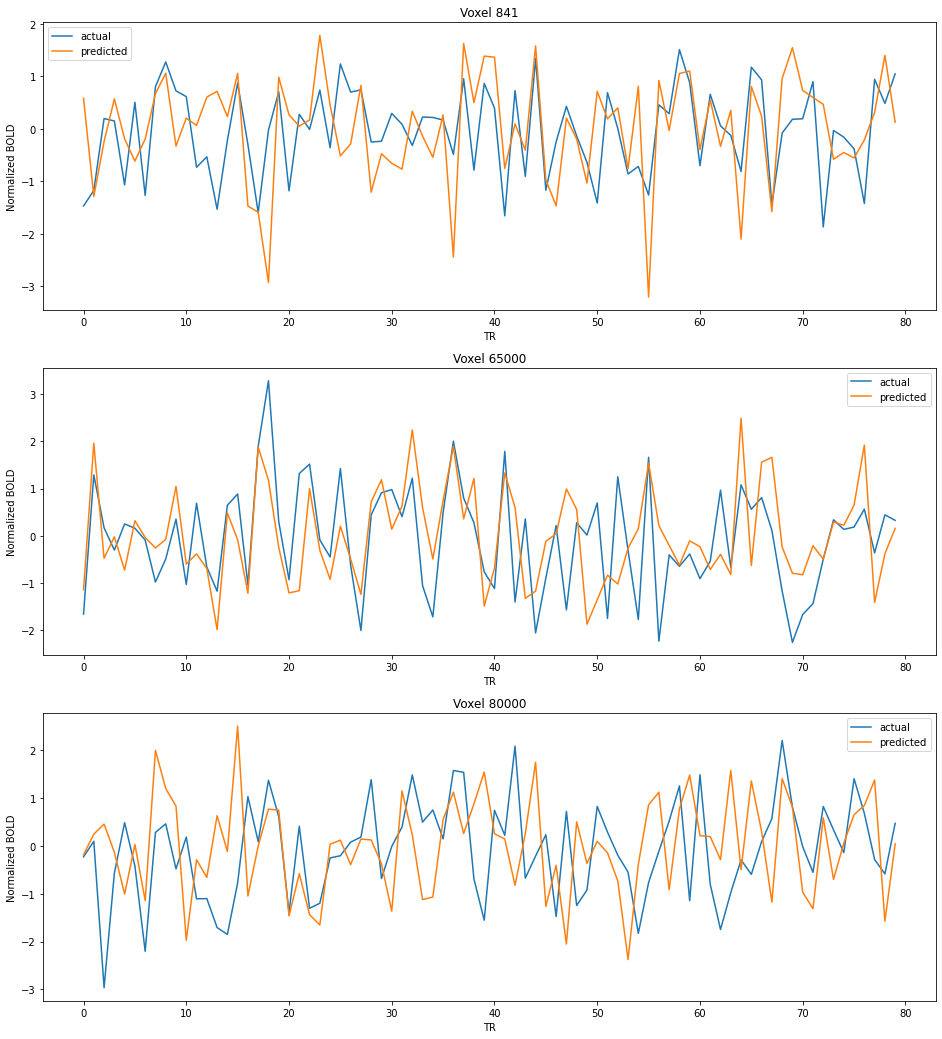

In [18]:
import matplotlib.pyplot as plt

voxels = [841,65000,80000]

num_voxels = len(voxels)

plt.figure(figsize=(16,6*num_voxels))

for i in range(num_voxels):
  plt.subplot(num_voxels, 1, i+1)
  plt.xlabel('TR')
  plt.ylabel('Normalized BOLD')
  plt.title('Voxel {:d}'.format(voxels[i]))
  plt.plot(actual[:,voxels[i]], label='actual')
  plt.plot(predicted[:,voxels[i]], label='predicted')
  plt.legend();